In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import KFold


def handle_outliers_iqr(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[feature] < lower_bound) | (df[feature] > upper_bound)
    return df[~outliers]

def convert_renovation_year(year):
    # Function to convert Renovation Year if bigger than 0 to 1
    return 1 if year > 0 else 0

def error(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.2f}, MAPE: {mape:.2f}, R2 Score: {r2:.2f}")
    # print('MAE: ', mean_absolute_error(y_true, y_pred))
    # print('MAPE: ', mean_absolute_percentage_error(y_true, y_pred))
    # print('r2 score: ', r2_score(y_true, y_pred)) #loss curve

# Load the dataset
df = pd.read_csv("./HousePriceIndia.csv")

# Drop rows with missing values
df.dropna(inplace=True)
# Convert 'number of bathrooms' from float to int
df['number of bathrooms'] = df['number of bathrooms'].astype(int)
df['number of floors'] = df['number of floors'].astype(int)
# Convert 'water front present' from float to int
df['waterfront present'] = df['waterfront present'].astype(int)
# Convert "Renovation Year" to binary (0 or 1)
df['Renovated'] = df['Renovation Year'].apply(convert_renovation_year)

# Handle outliers using IQR for the 'living area' feature
feature_with_outliers_living_area = 'living area'
df_no_outliers_living_area = handle_outliers_iqr(
    df, feature_with_outliers_living_area)

# Handle outliers using IQR for the 'lot area' feature
feature_with_outliers_lot_area = 'lot area'
df_no_outliers_lot_area = handle_outliers_iqr(
    df_no_outliers_living_area, feature_with_outliers_lot_area)

# Define independent variables (features) and dependent variable (target)
X = df_no_outliers_lot_area.drop(
    ['Price', 'id', 'Date', 'Postal Code', 'Renovation Year', 'Area of the basement', 'Area of the house'], axis=1)
y = df_no_outliers_lot_area['Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(

    X, y, test_size=0.2, random_state=13918)



# Create and train the linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Create and train the Ridge regression model with hyperparameter tuning
ridge_regressor = Ridge(alpha=1.0)  # You can experiment with different alpha values
ridge_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = regressor.predict(X_test)

# Get the accuracy
accuracy = regressor.score(X_test, y_test)
print(f"Linear Regression Accuracy: %{accuracy*100:.2f}")


# Perform Cross-Validation
cv_scores = cross_val_score(regressor, X_train, y_train, cv=5)  # 5-fold cross-validation

Linear Regression Accuracy: %74.61


In [5]:
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.68945902 0.70202719 0.68097451 0.68030588 0.6779178 ]
Mean CV Score: 0.6861368792568786


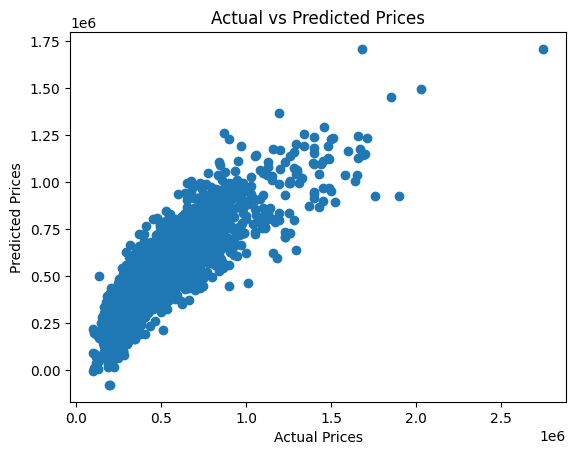

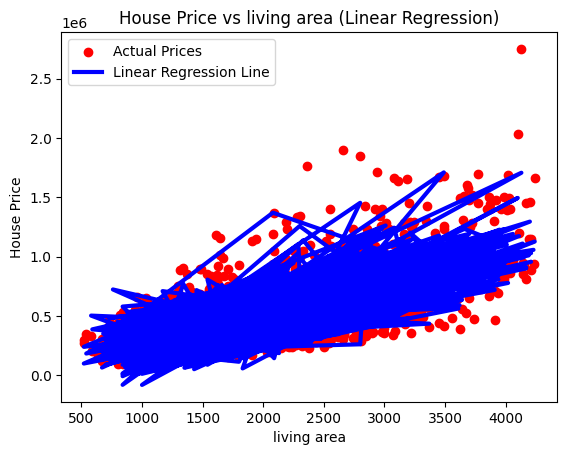

In [6]:

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted Prices")
plt.show()

# Plot the results for linear regression
plt.scatter(X_test[feature_with_outliers_living_area],
            y_test, color='red', label='Actual Prices')
plt.plot(X_test[feature_with_outliers_living_area], y_pred,
color='blue', linewidth=3, label='Linear Regression Line')
plt.title(f'House Price vs {feature_with_outliers_living_area} (Linear Regression)')
plt.xlabel(feature_with_outliers_living_area)
plt.ylabel('House Price')
plt.legend()
plt.show()

In [7]:
error(y_test, y_pred)

MAE: 95031.53, MAPE: 0.21, R2 Score: 0.75


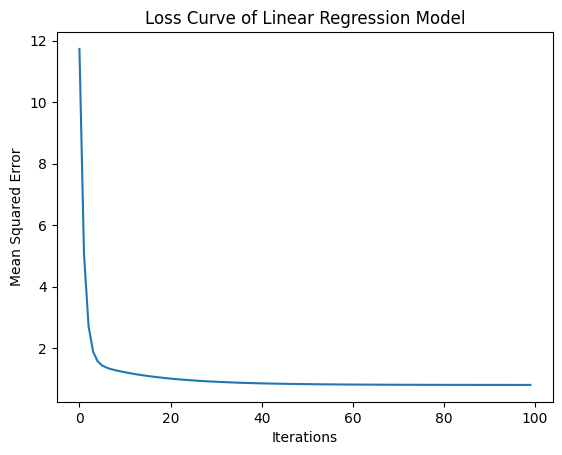

In [8]:
# Generate some random data for demonstration purposes
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Initialize the parameters for linear regression
eta = 0.1  # learning rate
n_iterations = 100
m = 100  # number of instances

# Random initialization of theta (weights)
theta = np.random.randn(2, 1)

# Perform gradient descent to fit the linear regression model
X_b = np.c_[np.ones((m, 1)), X]  # add x0 = 1 to each instance
losses = []

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta -= eta * gradients
    # Calculate mean squared error (loss) for current theta
    loss = np.mean((X_b.dot(theta) - y) ** 2)
    losses.append(loss)

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Mean Squared Error')
plt.title('Loss Curve of Linear Regression Model')
plt.show()

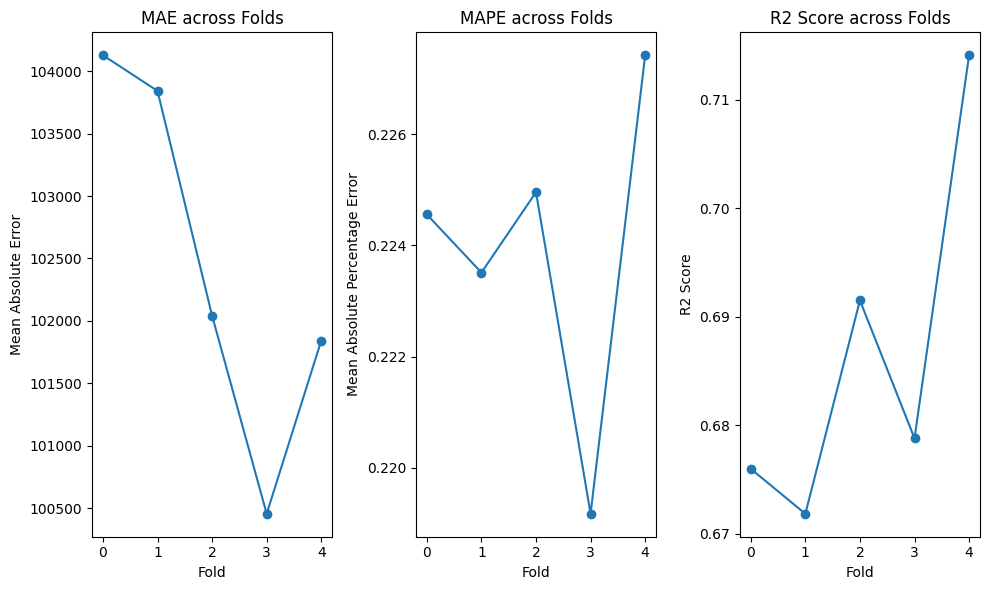

In [9]:
# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Define the number of splits (here, 5-fold)

# Empty lists to store metric scores for each fold
mae_scores = []
mape_scores = []
r2_scores = []  

# Perform Cross-Validation
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit the model
    regressor.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set
    y_pred_fold = regressor.predict(X_val_fold)

    # Calculate metrics for this fold
    mae_fold = mean_absolute_error(y_val_fold, y_pred_fold)
    mape_fold = mean_absolute_percentage_error(y_val_fold, y_pred_fold)
    r2_fold = r2_score(y_val_fold, y_pred_fold)

    # Append scores to lists
    mae_scores.append(mae_fold)
    mape_scores.append(mape_fold)
    r2_scores.append(r2_fold)

# Plotting the loss curve (Cross-Validation Scores)
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.plot(mae_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error')
plt.title('MAE across Folds')

plt.subplot(1, 3, 2)
plt.plot(mape_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Percentage Error')
plt.title('MAPE across Folds')

plt.subplot(1, 3, 3)
plt.plot(r2_scores, marker='o')
plt.xlabel('Fold')
plt.ylabel('R2 Score')
plt.title('R2 Score across Folds')

plt.tight_layout()
plt.show()

In [10]:
print("Train Set Size:", len(X_train))
print("Validation Set Size:", len(X_val_fold))
print("Test Set Size:", len(X_test))

Train Set Size: 10133
Validation Set Size: 2026
Test Set Size: 2534
